In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "E2F/DP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn073211,MAKMQLKRKSGTKYNEVGPSDWTSSPGCTDMANSPLRTPVSGKGGR...,363,1
1,Achn095861,MSLNKNLEDDSNQNHRVTWEGCSVLLDVNDGDRLVFARLTAASNLS...,761,1
2,Achn137321,MIAILRHLKAREVADELVAEFADSSNNLTSLDQPQYEEKNIRRRVY...,196,1
3,Achn142181,MLTLVKGPGLLIFSMRVFSLLVIYQPLKRKSEKTEFEAESSECNPS...,404,1
4,Achn186551,MSQNKNLEEDANQNPRVTWEGCSVLLDVNDGDRLVFARLTPASSLA...,531,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1069,0.016509,0.0,0.007075,0.007075,0.004717,0.004717,0.000000,0.000000,0.007075,0.007075,...,0.000000,0.0,0.004717,0.000000,0.004717,0.002358,0.000000,0.000000,0.0,0.0
1763,0.008439,0.0,0.008439,0.008439,0.000000,0.008439,0.000000,0.000000,0.000000,0.000000,...,0.004219,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3468,0.007117,0.0,0.003559,0.017794,0.000000,0.007117,0.000000,0.000000,0.000000,0.014235,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
312,0.002227,0.0,0.006682,0.008909,0.004454,0.000000,0.000000,0.002227,0.000000,0.002227,...,0.000000,0.0,0.002227,0.000000,0.004454,0.000000,0.000000,0.002227,0.0,0.0
304,0.007792,0.0,0.002597,0.002597,0.002597,0.000000,0.005195,0.002597,0.005195,0.007792,...,0.002597,0.0,0.005195,0.002597,0.005195,0.002597,0.002597,0.000000,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2829, 441)
X_test: (708, 441)
y_train: (2829,)
y_test: (708,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 33s 958ms/step - accuracy: 0.5781 - loss: 0.6930

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - loss: 0.6864   

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6652 - loss: 0.6811 - val_accuracy: 0.9558 - val_loss: 0.4950


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.4925

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.3653 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9592 - loss: 0.3476 - val_accuracy: 0.9629 - val_loss: 0.0894


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0614

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0652 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0672 - val_accuracy: 0.9859 - val_loss: 0.0566


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0752

26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0579 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.0578 - val_accuracy: 0.9806 - val_loss: 0.0555


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0729

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0444 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0448 - val_accuracy: 0.9894 - val_loss: 0.0473


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0310

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0321 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.0328 - val_accuracy: 0.9894 - val_loss: 0.0462


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0134

26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0258 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0280 - val_accuracy: 0.9823 - val_loss: 0.0560


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1121

26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0348 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0310 - val_accuracy: 0.9859 - val_loss: 0.0511


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 1.0000 - loss: 0.0134

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0270 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0268 - val_accuracy: 0.9894 - val_loss: 0.0517


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0694

26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0216 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.9806 - val_loss: 0.0676


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0030

15/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0224 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0223 - val_accuracy: 0.9788 - val_loss: 0.0701


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0041

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0237 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0229 - val_accuracy: 0.9876 - val_loss: 0.0533


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0081

26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0117 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0122 - val_accuracy: 0.9876 - val_loss: 0.0625


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0111

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0150 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0152 - val_accuracy: 0.9806 - val_loss: 0.0814


Epoch 15/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0190

27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0115 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0115 - val_accuracy: 0.9859 - val_loss: 0.0630



[Train Accuracy: 99.65% - Test Accuracy: 98.16%]


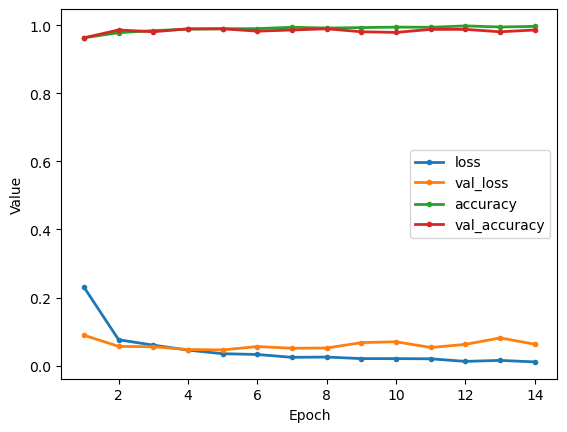

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1069,0.002364,0.0,0.002364,0.0,0.0,0.000000,0.0,0.0,0.002364,0.002364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,0.000000,0.0,0.000000,0.0,0.0,0.004237,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3468,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.002604,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2829, 8612)
X_test: (708, 8612)
y_train: (2829,)
y_test: (708,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,248,193 (8.58 MB)

 Trainable params: 2,248,193 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 22s 638ms/step - accuracy: 0.4375 - loss: 0.6932

 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4778 - loss: 0.6930   

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5124 - loss: 0.6921

24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5662 - loss: 0.6902

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6112 - loss: 0.6865

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6344 - loss: 0.6830 - val_accuracy: 0.9558 - val_loss: 0.5051


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9219 - loss: 0.5091

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9563 - loss: 0.4706 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9629 - loss: 0.4246

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9669 - loss: 0.3805

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9696 - loss: 0.3431

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9707 - loss: 0.3276 - val_accuracy: 0.9859 - val_loss: 0.0459


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0210

 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9947 - loss: 0.0215 

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.0228

24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9948 - loss: 0.0217

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9946 - loss: 0.0221

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9945 - loss: 0.0222 - val_accuracy: 0.9912 - val_loss: 0.0358


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9844 - loss: 0.0328

 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.0144 

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0113

24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0102

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0095

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0091 - val_accuracy: 0.9912 - val_loss: 0.0362


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0015

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9929 - val_loss: 0.0260


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.4835e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013     

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9912 - val_loss: 0.0361


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.8746e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7316e-04 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6241e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5797e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7383e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8590e-04 - val_accuracy: 0.9912 - val_loss: 0.0348


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.8991e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015     

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9912 - val_loss: 0.0492


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.7840e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0734e-04 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2260e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4998e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6054e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6331e-04 - val_accuracy: 0.9912 - val_loss: 0.0393


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6503e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2323e-04 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3227e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5280e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7170e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7525e-04 - val_accuracy: 0.9912 - val_loss: 0.0364


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6374e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5674e-04 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4616e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4110e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3817e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3754e-04 - val_accuracy: 0.9912 - val_loss: 0.0492


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.8080e-05

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9161e-05 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1060e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1513e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1524e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1478e-04 - val_accuracy: 0.9912 - val_loss: 0.0486


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.1907e-05

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8675e-05 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6993e-05

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8071e-05

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9284e-05

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8925e-05 - val_accuracy: 0.9912 - val_loss: 0.0487


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 7.0105e-05

 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5221e-05 

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9862e-05

24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0423e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1257e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1538e-04 - val_accuracy: 0.9912 - val_loss: 0.0505


Epoch 15/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.1723e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2070e-04 

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0511e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0139e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8281e-05

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7011e-05 - val_accuracy: 0.9912 - val_loss: 0.0528



[Train Accuracy: 100.00% - Test Accuracy: 99.15%]


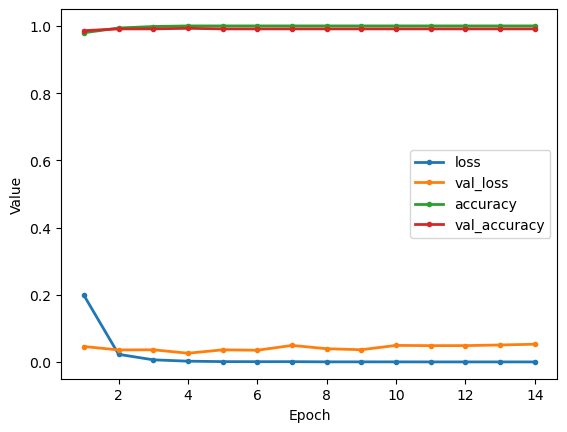

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1069,0.0,0.0,0.00237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3468,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,791,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,832,449 (129.06 MB)

 Trainable params: 33,832,449 (129.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 30s 861ms/step - accuracy: 0.6094 - loss: 0.6931

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5898 - loss: 0.6931 

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5720 - loss: 0.6931

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5658 - loss: 0.6931

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5639 - loss: 0.6930

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5641 - loss: 0.6929

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5635 - loss: 0.6927

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5636 - loss: 0.6926

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5620 - loss: 0.6925

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5605 - loss: 0.6924

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5588 - loss: 0.6923

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5574 - loss: 0.6922

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5563 - loss: 0.6921

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5548 - loss: 0.6920

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5531 - loss: 0.6919

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5512 - loss: 0.6918

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5493 - loss: 0.6916

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5485 - loss: 0.6915

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5487 - loss: 0.6913

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5498 - loss: 0.6912

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5517 - loss: 0.6910

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5542 - loss: 0.6907

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5572 - loss: 0.6905

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5606 - loss: 0.6902

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5642 - loss: 0.6898

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5680 - loss: 0.6895

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5720 - loss: 0.6891

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5761 - loss: 0.6887

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5803 - loss: 0.6883

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5846 - loss: 0.6878

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5888 - loss: 0.6873

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5930 - loss: 0.6867

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5973 - loss: 0.6861

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6014 - loss: 0.6855

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6055 - loss: 0.6848

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6095 - loss: 0.6841

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6132 - loss: 0.6834 - val_accuracy: 0.9841 - val_loss: 0.5310


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 1.0000 - loss: 0.5022

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.5046

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9983 - loss: 0.5020

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9977 - loss: 0.4997

 5/36 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9976 - loss: 0.4964

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9975 - loss: 0.4928

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9976 - loss: 0.4883

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9976 - loss: 0.4839

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9975 - loss: 0.4793

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9973 - loss: 0.4749

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9970 - loss: 0.4704

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9967 - loss: 0.4658

13/36 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9963 - loss: 0.4611

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9959 - loss: 0.4563

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9957 - loss: 0.4515

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9954 - loss: 0.4467

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9952 - loss: 0.4419

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9949 - loss: 0.4372

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9947 - loss: 0.4324

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9945 - loss: 0.4277

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9943 - loss: 0.4229

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9941 - loss: 0.4182

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9939 - loss: 0.4135

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9937 - loss: 0.4088

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9936 - loss: 0.4042

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9935 - loss: 0.3996

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9933 - loss: 0.3950

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9932 - loss: 0.3906

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9931 - loss: 0.3862

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9929 - loss: 0.3820

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9928 - loss: 0.3778

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9926 - loss: 0.3737

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9925 - loss: 0.3697

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9923 - loss: 0.3658

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9922 - loss: 0.3619

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9921 - loss: 0.3582

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9920 - loss: 0.3547 - val_accuracy: 0.9788 - val_loss: 0.0627


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9844 - loss: 0.0582

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9844 - loss: 0.0536

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9844 - loss: 0.0510

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9854 - loss: 0.0476

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9864 - loss: 0.0447

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9874 - loss: 0.0421

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9882 - loss: 0.0400

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9887 - loss: 0.0385

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9892 - loss: 0.0372

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9897 - loss: 0.0360

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9901 - loss: 0.0350

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9905 - loss: 0.0339

13/36 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9908 - loss: 0.0330

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9912 - loss: 0.0321

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9915 - loss: 0.0314

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9918 - loss: 0.0307

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9920 - loss: 0.0300

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9923 - loss: 0.0295

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9925 - loss: 0.0289

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9927 - loss: 0.0284

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9929 - loss: 0.0279

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9931 - loss: 0.0275

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9933 - loss: 0.0270

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9935 - loss: 0.0266

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9936 - loss: 0.0261

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9938 - loss: 0.0257

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9939 - loss: 0.0254

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9941 - loss: 0.0250

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9942 - loss: 0.0246

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9943 - loss: 0.0243

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9944 - loss: 0.0240

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9945 - loss: 0.0237

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9946 - loss: 0.0234

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9947 - loss: 0.0232

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9947 - loss: 0.0229

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9948 - loss: 0.0227

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9949 - loss: 0.0225 - val_accuracy: 0.9912 - val_loss: 0.0350


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 1.0000 - loss: 0.0024

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0029

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0033

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0035

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0037

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0038

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0039

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0040

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0040

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0041

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0042

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0042

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0042

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0042

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0041

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0041

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0041

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0041

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0040

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0040

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0040

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0040

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0040

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0039

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0039

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0039

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0038

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0038

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0038

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0038

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0037

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9894 - val_loss: 0.0471


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 0.0012

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0015

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0016

 5/36 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0016

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0016

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0016

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0016

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0016

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0016

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0015

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0015

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0015

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0014

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0014

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0014

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0014

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0014

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0014

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0014

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0014

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9912 - val_loss: 0.0384


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 0.0011

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0012

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0011

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0011

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0010

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0010

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0010

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0010

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0010

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0010

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 9.9920e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 9.9310e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 9.8881e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.8184e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.7473e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.6741e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.6000e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.5334e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.4645e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 9.4013e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 9.3377e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 9.2693e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 9.2052e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 9.1413e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 9.0759e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 9.0146e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 8.9550e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.8961e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.8399e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.7817e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.7276e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.6798e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.6325e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.5855e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.5396e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 8.4968e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.4563e-04 - val_accuracy: 0.9894 - val_loss: 0.0493


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 6.1711e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.3947e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.0522e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.8220e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.7814e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.7350e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.6878e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6542e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6100e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.5584e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.5021e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5189e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5346e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5430e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5405e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5448e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5514e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5524e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.5513e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.5696e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.5820e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.6392e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.6865e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7232e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7542e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7858e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.8101e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8299e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8447e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8575e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8678e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8800e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8892e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.8965e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.9122e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.9271e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.9412e-04 - val_accuracy: 0.9894 - val_loss: 0.0438


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 3.8945e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.4566e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.3853e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3502e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2811e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.2248e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2358e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.2233e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1931e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1679e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.1287e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0948e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0753e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0534e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0279e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9969e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9671e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9486e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 3.9271e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9187e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.9067e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.8934e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.9080e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9190e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9251e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9267e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9254e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9224e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.9198e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.9173e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.9134e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.9076e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.9014e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.8941e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.8859e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.8777e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.8700e-04 - val_accuracy: 0.9894 - val_loss: 0.0466


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 2.3973e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.2731e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.2395e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 2.1779e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.1744e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 2.1807e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.1775e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.1780e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.1798e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.1840e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.2018e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 2.2123e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 2.2880e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.3514e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.4004e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.4355e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.4628e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.4823e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.4969e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.5062e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.5123e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.5155e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5210e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5254e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5338e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5439e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5529e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5600e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5670e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5724e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5764e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5786e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.5796e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5795e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5784e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.5773e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.5761e-04 - val_accuracy: 0.9894 - val_loss: 0.0504


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.1921e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.2903e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.6320e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.7277e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.7619e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.8134e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.8474e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.9301e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.9792e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.0067e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.0238e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.0293e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.0283e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.0337e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 2.0396e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.0426e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.0431e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.0415e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.0377e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0314e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0244e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0160e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0073e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0086e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0091e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0098e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.0093e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.0077e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.0057e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.0026e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.0000e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9966e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9930e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9886e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9838e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.9792e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.9748e-04 - val_accuracy: 0.9894 - val_loss: 0.0523


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 1.3580e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2812e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.2875e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2830e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2749e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2635e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.2455e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2221e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2062e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.1966e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.1881e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.1797e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.1743e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.1728e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.1753e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.1789e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.1837e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.1880e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2091e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2262e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.2423e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.2560e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2672e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2768e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2848e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2924e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2991e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3048e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3098e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3134e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3206e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3270e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3327e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3372e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3416e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3458e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.3497e-04 - val_accuracy: 0.9894 - val_loss: 0.0517


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 8.2077e-05

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.0057e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.0638e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.1235e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.1598e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1773e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1942e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.1968e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1957e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1945e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1985e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.2015e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2005e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.1991e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2033e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2044e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2033e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2013e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2036e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2056e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2059e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2062e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2056e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.2044e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2043e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2040e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2035e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.2031e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2044e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2051e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2055e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2059e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2058e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2073e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2085e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.2094e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.2102e-04 - val_accuracy: 0.9894 - val_loss: 0.0528


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.6662e-04

 2/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4924e-04

 3/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4223e-04

 4/36 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.3374e-04

 5/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.2573e-04

 6/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1989e-04

 7/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1640e-04

 8/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1364e-04

 9/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1266e-04

10/36 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1199e-04

11/36 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1103e-04

12/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.1004e-04

13/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0902e-04

14/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0797e-04

15/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0701e-04

16/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0620e-04

17/36 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0532e-04

18/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0458e-04

19/36 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0413e-04

20/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0368e-04

21/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0320e-04

22/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0314e-04

23/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0311e-04

24/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0298e-04

25/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0287e-04

26/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0281e-04

27/36 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0268e-04

28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0253e-04

29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0236e-04

30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0217e-04

31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0198e-04

32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0176e-04

33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0155e-04

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0260e-04

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.0354e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0441e-04

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.0523e-04 - val_accuracy: 0.9894 - val_loss: 0.0503



[Train Accuracy: 100.00% - Test Accuracy: 98.87%]


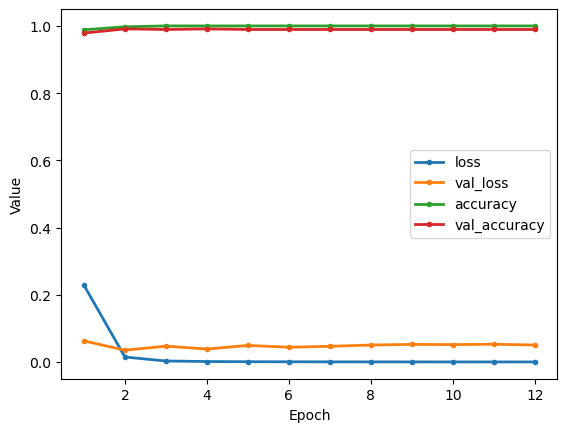

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

 5/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

10/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

15/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 6/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/E2F__DP/report_BPNTB6VH.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################